##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Transfer learning and fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

   16384/68606236 [..............................] - ETA: 0s

 4202496/68606236 [>.............................] - ETA: 7s

 8396800/68606236 [==>...........................] - ETA: 11s

13459456/68606236 [====>.........................] - ETA: 6s 

20176896/68606236 [=======>......................] - ETA: 3s

28786688/68606236 [===========>..................] - ETA: 2s

37208064/68606236 [===============>..............] - ETA: 1s

41811968/68606236 [=================>............] - ETA: 1s

41951232/68606236 [=================>............] - ETA: 1s

50339840/68606236 [=====================>........] - ETA: 0s

50528256/68606236 [=====================>........] - ETA: 0s

57384960/68606236 [========================>.....] - ETA: 0s

67059712/68606236 [============================>.] - ETA: 0s

68608000/68606236 [==============================] - 3s 0us/step


68616192/68606236 [==============================] - 3s 0us/step


Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

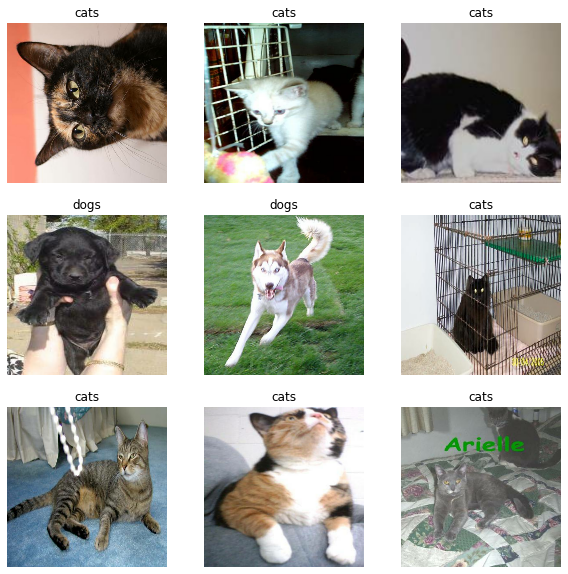

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

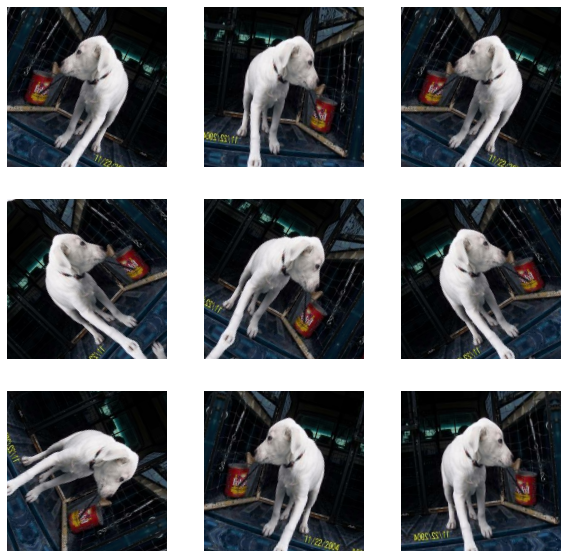

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

  16384/9406464 [..............................] - ETA: 0s

5267456/9406464 [===============>..............] - ETA: 0s

9412608/9406464 [==============================] - 0s 0us/step


9420800/9406464 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [16]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

 1/26 [>.............................] - ETA: 36s - loss: 0.6358 - accuracy: 0.6250

 5/26 [====>.........................] - ETA: 0s - loss: 0.6878 - accuracy: 0.6000 

 9/26 [=========>....................] - ETA: 0s - loss: 0.6670 - accuracy: 0.5938

13/26 [==============>...............] - ETA: 0s - loss: 0.6667 - accuracy: 0.6058

17/26 [==================>...........] - ETA: 0s - loss: 0.6555 - accuracy: 0.6085

22/26 [========================>.....] - ETA: 0s - loss: 0.6492 - accuracy: 0.6080

26/26 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.6089

26/26 [==============================] - 2s 17ms/step - loss: 0.6467 - accuracy: 0.6089


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.65
initial accuracy: 0.61


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


 1/63 [..............................] - ETA: 2:35 - loss: 0.5638 - accuracy: 0.6875

 4/63 [>.............................] - ETA: 1s - loss: 0.6044 - accuracy: 0.6875  

 8/63 [==>...........................] - ETA: 0s - loss: 0.6227 - accuracy: 0.6484

12/63 [====>.........................] - ETA: 0s - loss: 0.6326 - accuracy: 0.6354

16/63 [======>.......................] - ETA: 0s - loss: 0.6284 - accuracy: 0.6543

20/63 [========>.....................] - ETA: 0s - loss: 0.6143 - accuracy: 0.6625

24/63 [==========>...................] - ETA: 0s - loss: 0.6036 - accuracy: 0.6680

28/63 [============>.................] - ETA: 0s - loss: 0.6019 - accuracy: 0.6719

32/63 [==============>...............] - ETA: 0s - loss: 0.5950 - accuracy: 0.6777

36/63 [================>.............] - ETA: 0s - loss: 0.5903 - accuracy: 0.6840

40/63 [==================>...........] - ETA: 0s - loss: 0.5933 - accuracy: 0.6781

44/63 [===================>..........] - ETA: 0s - loss: 0.5895 - accuracy: 0.6839

48/63 [=====================>........] - ETA: 0s - loss: 0.5936 - accuracy: 0.6790

52/63 [=======================>......] - ETA: 0s - loss: 0.5904 - accuracy: 0.6785

56/63 [=========================>....] - ETA: 0s - loss: 0.5885 - accuracy: 0.6747

60/63 [===========================>..] - ETA: 0s - loss: 0.5834 - accuracy: 0.6786

63/63 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.6795

63/63 [==============================] - 4s 23ms/step - loss: 0.5797 - accuracy: 0.6795 - val_loss: 0.4490 - val_accuracy: 0.7438


Epoch 2/10
 1/63 [..............................] - ETA: 5s - loss: 0.4187 - accuracy: 0.8438

 5/63 [=>............................] - ETA: 0s - loss: 0.4045 - accuracy: 0.8062

 9/63 [===>..........................] - ETA: 0s - loss: 0.4334 - accuracy: 0.7847

13/63 [=====>........................] - ETA: 0s - loss: 0.4456 - accuracy: 0.7668

17/63 [=======>......................] - ETA: 0s - loss: 0.4381 - accuracy: 0.7739

21/63 [=========>....................] - ETA: 0s - loss: 0.4503 - accuracy: 0.7723

25/63 [==========>...................] - ETA: 0s - loss: 0.4489 - accuracy: 0.7725

29/63 [============>.................] - ETA: 0s - loss: 0.4474 - accuracy: 0.7726

33/63 [==============>...............] - ETA: 0s - loss: 0.4506 - accuracy: 0.7699

37/63 [================>.............] - ETA: 0s - loss: 0.4466 - accuracy: 0.7703

41/63 [==================>...........] - ETA: 0s - loss: 0.4456 - accuracy: 0.7713

45/63 [====================>.........] - ETA: 0s - loss: 0.4474 - accuracy: 0.7688

49/63 [======================>.......] - ETA: 0s - loss: 0.4428 - accuracy: 0.7685

53/63 [========================>.....] - ETA: 0s - loss: 0.4386 - accuracy: 0.7706

57/63 [==========================>...] - ETA: 0s - loss: 0.4351 - accuracy: 0.7752

61/63 [============================>.] - ETA: 0s - loss: 0.4345 - accuracy: 0.7746

63/63 [==============================] - 1s 22ms/step - loss: 0.4334 - accuracy: 0.7760 - val_loss: 0.3312 - val_accuracy: 0.8292


Epoch 3/10
 1/63 [..............................] - ETA: 5s - loss: 0.2701 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.3606 - accuracy: 0.8000

 9/63 [===>..........................] - ETA: 0s - loss: 0.3804 - accuracy: 0.7917

13/63 [=====>........................] - ETA: 0s - loss: 0.3825 - accuracy: 0.7909

17/63 [=======>......................] - ETA: 0s - loss: 0.3964 - accuracy: 0.7868

21/63 [=========>....................] - ETA: 0s - loss: 0.3874 - accuracy: 0.8051

25/63 [==========>...................] - ETA: 0s - loss: 0.3834 - accuracy: 0.8062

29/63 [============>.................] - ETA: 0s - loss: 0.3776 - accuracy: 0.8082

33/63 [==============>...............] - ETA: 0s - loss: 0.3758 - accuracy: 0.8116

37/63 [================>.............] - ETA: 0s - loss: 0.3743 - accuracy: 0.8142

41/63 [==================>...........] - ETA: 0s - loss: 0.3816 - accuracy: 0.8155

45/63 [====================>.........] - ETA: 0s - loss: 0.3772 - accuracy: 0.8167

49/63 [======================>.......] - ETA: 0s - loss: 0.3751 - accuracy: 0.8151

53/63 [========================>.....] - ETA: 0s - loss: 0.3727 - accuracy: 0.8137

57/63 [==========================>...] - ETA: 0s - loss: 0.3671 - accuracy: 0.8158

61/63 [============================>.] - ETA: 0s - loss: 0.3692 - accuracy: 0.8156

63/63 [==============================] - 1s 21ms/step - loss: 0.3706 - accuracy: 0.8150 - val_loss: 0.2652 - val_accuracy: 0.8911


Epoch 4/10
 1/63 [..............................] - ETA: 5s - loss: 0.3536 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.3070 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 0s - loss: 0.2957 - accuracy: 0.8750

13/63 [=====>........................] - ETA: 0s - loss: 0.3190 - accuracy: 0.8486

17/63 [=======>......................] - ETA: 0s - loss: 0.3248 - accuracy: 0.8566

21/63 [=========>....................] - ETA: 0s - loss: 0.3187 - accuracy: 0.8557

25/63 [==========>...................] - ETA: 0s - loss: 0.3209 - accuracy: 0.8525

29/63 [============>.................] - ETA: 0s - loss: 0.3209 - accuracy: 0.8556

33/63 [==============>...............] - ETA: 0s - loss: 0.3225 - accuracy: 0.8504

37/63 [================>.............] - ETA: 0s - loss: 0.3239 - accuracy: 0.8505

41/63 [==================>...........] - ETA: 0s - loss: 0.3229 - accuracy: 0.8521

45/63 [====================>.........] - ETA: 0s - loss: 0.3192 - accuracy: 0.8528

49/63 [======================>.......] - ETA: 0s - loss: 0.3214 - accuracy: 0.8501

53/63 [========================>.....] - ETA: 0s - loss: 0.3235 - accuracy: 0.8479

57/63 [==========================>...] - ETA: 0s - loss: 0.3229 - accuracy: 0.8503

61/63 [============================>.] - ETA: 0s - loss: 0.3210 - accuracy: 0.8525

63/63 [==============================] - 1s 21ms/step - loss: 0.3224 - accuracy: 0.8530 - val_loss: 0.2206 - val_accuracy: 0.9072


Epoch 5/10
 1/63 [..............................] - ETA: 5s - loss: 0.2077 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.2678 - accuracy: 0.8875

 9/63 [===>..........................] - ETA: 0s - loss: 0.2839 - accuracy: 0.8681

13/63 [=====>........................] - ETA: 0s - loss: 0.2776 - accuracy: 0.8774

17/63 [=======>......................] - ETA: 0s - loss: 0.2620 - accuracy: 0.8824

21/63 [=========>....................] - ETA: 0s - loss: 0.2691 - accuracy: 0.8810

25/63 [==========>...................] - ETA: 0s - loss: 0.2710 - accuracy: 0.8813

29/63 [============>.................] - ETA: 0s - loss: 0.2719 - accuracy: 0.8825

33/63 [==============>...............] - ETA: 0s - loss: 0.2689 - accuracy: 0.8816

37/63 [================>.............] - ETA: 0s - loss: 0.2713 - accuracy: 0.8818

41/63 [==================>...........] - ETA: 0s - loss: 0.2741 - accuracy: 0.8803

45/63 [====================>.........] - ETA: 0s - loss: 0.2714 - accuracy: 0.8833

49/63 [======================>.......] - ETA: 0s - loss: 0.2713 - accuracy: 0.8820

53/63 [========================>.....] - ETA: 0s - loss: 0.2750 - accuracy: 0.8756

57/63 [==========================>...] - ETA: 0s - loss: 0.2750 - accuracy: 0.8783

61/63 [============================>.] - ETA: 0s - loss: 0.2754 - accuracy: 0.8776

63/63 [==============================] - 1s 21ms/step - loss: 0.2732 - accuracy: 0.8795 - val_loss: 0.1924 - val_accuracy: 0.9208


Epoch 6/10
 1/63 [..............................] - ETA: 5s - loss: 0.2304 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.2706 - accuracy: 0.8875

 9/63 [===>..........................] - ETA: 0s - loss: 0.2894 - accuracy: 0.8681

13/63 [=====>........................] - ETA: 0s - loss: 0.2831 - accuracy: 0.8654

17/63 [=======>......................] - ETA: 0s - loss: 0.2807 - accuracy: 0.8676

21/63 [=========>....................] - ETA: 0s - loss: 0.2845 - accuracy: 0.8720

25/63 [==========>...................] - ETA: 0s - loss: 0.2757 - accuracy: 0.8800

29/63 [============>.................] - ETA: 0s - loss: 0.2774 - accuracy: 0.8793

33/63 [==============>...............] - ETA: 0s - loss: 0.2795 - accuracy: 0.8750

37/63 [================>.............] - ETA: 0s - loss: 0.2714 - accuracy: 0.8801

41/63 [==================>...........] - ETA: 0s - loss: 0.2655 - accuracy: 0.8857

45/63 [====================>.........] - ETA: 0s - loss: 0.2680 - accuracy: 0.8806

49/63 [======================>.......] - ETA: 0s - loss: 0.2701 - accuracy: 0.8814

53/63 [========================>.....] - ETA: 0s - loss: 0.2721 - accuracy: 0.8791

57/63 [==========================>...] - ETA: 0s - loss: 0.2706 - accuracy: 0.8788

61/63 [============================>.] - ETA: 0s - loss: 0.2712 - accuracy: 0.8786

63/63 [==============================] - 1s 21ms/step - loss: 0.2716 - accuracy: 0.8785 - val_loss: 0.1653 - val_accuracy: 0.9344


Epoch 7/10
 1/63 [..............................] - ETA: 5s - loss: 0.2583 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.2266 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 0s - loss: 0.2197 - accuracy: 0.9028

13/63 [=====>........................] - ETA: 0s - loss: 0.2310 - accuracy: 0.8966

17/63 [=======>......................] - ETA: 0s - loss: 0.2285 - accuracy: 0.8952

21/63 [=========>....................] - ETA: 0s - loss: 0.2274 - accuracy: 0.8973

25/63 [==========>...................] - ETA: 0s - loss: 0.2251 - accuracy: 0.8988

29/63 [============>.................] - ETA: 0s - loss: 0.2240 - accuracy: 0.9019

33/63 [==============>...............] - ETA: 0s - loss: 0.2340 - accuracy: 0.8968

37/63 [================>.............] - ETA: 0s - loss: 0.2383 - accuracy: 0.8995

41/63 [==================>...........] - ETA: 0s - loss: 0.2376 - accuracy: 0.9002

45/63 [====================>.........] - ETA: 0s - loss: 0.2360 - accuracy: 0.9000

49/63 [======================>.......] - ETA: 0s - loss: 0.2354 - accuracy: 0.9031

53/63 [========================>.....] - ETA: 0s - loss: 0.2358 - accuracy: 0.9039

57/63 [==========================>...] - ETA: 0s - loss: 0.2369 - accuracy: 0.9041

61/63 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9047

63/63 [==============================] - 1s 21ms/step - loss: 0.2338 - accuracy: 0.9055 - val_loss: 0.1464 - val_accuracy: 0.9455


Epoch 8/10
 1/63 [..............................] - ETA: 5s - loss: 0.1600 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.1901 - accuracy: 0.9312

 9/63 [===>..........................] - ETA: 0s - loss: 0.2064 - accuracy: 0.9201

13/63 [=====>........................] - ETA: 0s - loss: 0.2120 - accuracy: 0.9231

17/63 [=======>......................] - ETA: 0s - loss: 0.2115 - accuracy: 0.9210

21/63 [=========>....................] - ETA: 0s - loss: 0.2090 - accuracy: 0.9196

25/63 [==========>...................] - ETA: 0s - loss: 0.2049 - accuracy: 0.9225

29/63 [============>.................] - ETA: 0s - loss: 0.2024 - accuracy: 0.9224

33/63 [==============>...............] - ETA: 0s - loss: 0.2035 - accuracy: 0.9176

37/63 [================>.............] - ETA: 0s - loss: 0.2020 - accuracy: 0.9181

41/63 [==================>...........] - ETA: 0s - loss: 0.2025 - accuracy: 0.9177

45/63 [====================>.........] - ETA: 0s - loss: 0.2067 - accuracy: 0.9153

49/63 [======================>.......] - ETA: 0s - loss: 0.2066 - accuracy: 0.9165

53/63 [========================>.....] - ETA: 0s - loss: 0.2067 - accuracy: 0.9139

57/63 [==========================>...] - ETA: 0s - loss: 0.2045 - accuracy: 0.9145

61/63 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9150

63/63 [==============================] - 1s 21ms/step - loss: 0.2062 - accuracy: 0.9150 - val_loss: 0.1387 - val_accuracy: 0.9468


Epoch 9/10
 1/63 [..............................] - ETA: 5s - loss: 0.2511 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 0s - loss: 0.2228 - accuracy: 0.8938

 9/63 [===>..........................] - ETA: 0s - loss: 0.1954 - accuracy: 0.9097

13/63 [=====>........................] - ETA: 0s - loss: 0.2072 - accuracy: 0.9062

17/63 [=======>......................] - ETA: 0s - loss: 0.1972 - accuracy: 0.9191

21/63 [=========>....................] - ETA: 0s - loss: 0.2024 - accuracy: 0.9167

25/63 [==========>...................] - ETA: 0s - loss: 0.1982 - accuracy: 0.9200

29/63 [============>.................] - ETA: 0s - loss: 0.2013 - accuracy: 0.9170

33/63 [==============>...............] - ETA: 0s - loss: 0.2092 - accuracy: 0.9110

37/63 [================>.............] - ETA: 0s - loss: 0.2082 - accuracy: 0.9105

41/63 [==================>...........] - ETA: 0s - loss: 0.2037 - accuracy: 0.9123

45/63 [====================>.........] - ETA: 0s - loss: 0.2026 - accuracy: 0.9146

49/63 [======================>.......] - ETA: 0s - loss: 0.2022 - accuracy: 0.9165

53/63 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 0.9175

57/63 [==========================>...] - ETA: 0s - loss: 0.2047 - accuracy: 0.9145

61/63 [============================>.] - ETA: 0s - loss: 0.2047 - accuracy: 0.9144

63/63 [==============================] - 1s 21ms/step - loss: 0.2027 - accuracy: 0.9155 - val_loss: 0.1269 - val_accuracy: 0.9530


Epoch 10/10
 1/63 [..............................] - ETA: 5s - loss: 0.1310 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.2181 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 0s - loss: 0.2140 - accuracy: 0.8958

13/63 [=====>........................] - ETA: 0s - loss: 0.2133 - accuracy: 0.9014

17/63 [=======>......................] - ETA: 0s - loss: 0.2155 - accuracy: 0.9026

21/63 [=========>....................] - ETA: 0s - loss: 0.2073 - accuracy: 0.9077

25/63 [==========>...................] - ETA: 0s - loss: 0.2051 - accuracy: 0.9100

29/63 [============>.................] - ETA: 0s - loss: 0.2075 - accuracy: 0.9116

33/63 [==============>...............] - ETA: 0s - loss: 0.2084 - accuracy: 0.9129

37/63 [================>.............] - ETA: 0s - loss: 0.2091 - accuracy: 0.9113

41/63 [==================>...........] - ETA: 0s - loss: 0.2112 - accuracy: 0.9131

45/63 [====================>.........] - ETA: 0s - loss: 0.2159 - accuracy: 0.9111

49/63 [======================>.......] - ETA: 0s - loss: 0.2159 - accuracy: 0.9094

53/63 [========================>.....] - ETA: 0s - loss: 0.2113 - accuracy: 0.9110

57/63 [==========================>...] - ETA: 0s - loss: 0.2093 - accuracy: 0.9106

61/63 [============================>.] - ETA: 0s - loss: 0.2074 - accuracy: 0.9109

63/63 [==============================] - 1s 21ms/step - loss: 0.2087 - accuracy: 0.9090 - val_loss: 0.1195 - val_accuracy: 0.9579


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

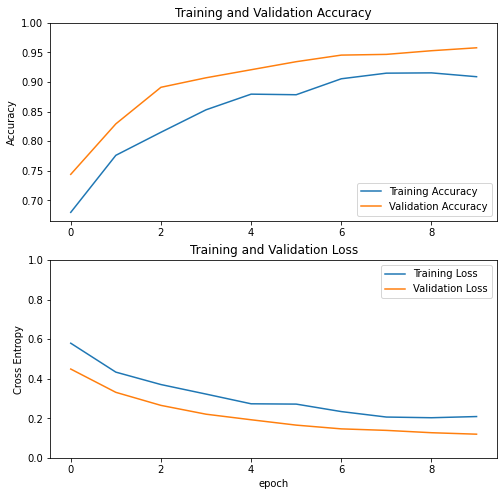

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


 1/63 [..............................] - ETA: 4:21 - loss: 0.1775 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.2645 - accuracy: 0.8906  

 7/63 [==>...........................] - ETA: 1s - loss: 0.2325 - accuracy: 0.9196

10/63 [===>..........................] - ETA: 1s - loss: 0.2124 - accuracy: 0.9187

13/63 [=====>........................] - ETA: 1s - loss: 0.2001 - accuracy: 0.9159

16/63 [======>.......................] - ETA: 1s - loss: 0.1872 - accuracy: 0.9199

19/63 [========>.....................] - ETA: 1s - loss: 0.1837 - accuracy: 0.9194

22/63 [=========>....................] - ETA: 0s - loss: 0.1793 - accuracy: 0.9190

25/63 [==========>...................] - ETA: 0s - loss: 0.1790 - accuracy: 0.9187

28/63 [============>.................] - ETA: 0s - loss: 0.1746 - accuracy: 0.9219

31/63 [=============>................] - ETA: 0s - loss: 0.1742 - accuracy: 0.9204

34/63 [===============>..............] - ETA: 0s - loss: 0.1733 - accuracy: 0.9219

37/63 [================>.............] - ETA: 0s - loss: 0.1679 - accuracy: 0.9240

40/63 [==================>...........] - ETA: 0s - loss: 0.1674 - accuracy: 0.9258

43/63 [===================>..........] - ETA: 0s - loss: 0.1705 - accuracy: 0.9244

46/63 [====================>.........] - ETA: 0s - loss: 0.1653 - accuracy: 0.9273

49/63 [======================>.......] - ETA: 0s - loss: 0.1692 - accuracy: 0.9260

52/63 [=======================>......] - ETA: 0s - loss: 0.1697 - accuracy: 0.9267

55/63 [=========================>....] - ETA: 0s - loss: 0.1697 - accuracy: 0.9267

58/63 [==========================>...] - ETA: 0s - loss: 0.1659 - accuracy: 0.9278

61/63 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9278

63/63 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9295

63/63 [==============================] - 7s 41ms/step - loss: 0.1645 - accuracy: 0.9295 - val_loss: 0.0580 - val_accuracy: 0.9752


Epoch 11/20
 1/63 [..............................] - ETA: 5s - loss: 0.1375 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.1300 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 1s - loss: 0.1380 - accuracy: 0.9554

10/63 [===>..........................] - ETA: 1s - loss: 0.1448 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 1s - loss: 0.1474 - accuracy: 0.9519

16/63 [======>.......................] - ETA: 1s - loss: 0.1508 - accuracy: 0.9473

19/63 [========>.....................] - ETA: 0s - loss: 0.1387 - accuracy: 0.9523

22/63 [=========>....................] - ETA: 0s - loss: 0.1330 - accuracy: 0.9531

25/63 [==========>...................] - ETA: 0s - loss: 0.1322 - accuracy: 0.9525

28/63 [============>.................] - ETA: 0s - loss: 0.1299 - accuracy: 0.9520

31/63 [=============>................] - ETA: 0s - loss: 0.1276 - accuracy: 0.9516

34/63 [===============>..............] - ETA: 0s - loss: 0.1314 - accuracy: 0.9476

37/63 [================>.............] - ETA: 0s - loss: 0.1285 - accuracy: 0.9493

40/63 [==================>...........] - ETA: 0s - loss: 0.1303 - accuracy: 0.9469

43/63 [===================>..........] - ETA: 0s - loss: 0.1248 - accuracy: 0.9491

46/63 [====================>.........] - ETA: 0s - loss: 0.1218 - accuracy: 0.9504

49/63 [======================>.......] - ETA: 0s - loss: 0.1233 - accuracy: 0.9490

52/63 [=======================>......] - ETA: 0s - loss: 0.1227 - accuracy: 0.9495

55/63 [=========================>....] - ETA: 0s - loss: 0.1179 - accuracy: 0.9523

58/63 [==========================>...] - ETA: 0s - loss: 0.1165 - accuracy: 0.9520

61/63 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9513

63/63 [==============================] - 2s 29ms/step - loss: 0.1136 - accuracy: 0.9520 - val_loss: 0.0473 - val_accuracy: 0.9851


Epoch 12/20
 1/63 [..............................] - ETA: 5s - loss: 0.0596 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.1147 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 1s - loss: 0.0854 - accuracy: 0.9598

10/63 [===>..........................] - ETA: 1s - loss: 0.0891 - accuracy: 0.9594

13/63 [=====>........................] - ETA: 1s - loss: 0.0837 - accuracy: 0.9639

16/63 [======>.......................] - ETA: 1s - loss: 0.0825 - accuracy: 0.9648

19/63 [========>.....................] - ETA: 1s - loss: 0.0862 - accuracy: 0.9622

22/63 [=========>....................] - ETA: 0s - loss: 0.0836 - accuracy: 0.9631

25/63 [==========>...................] - ETA: 0s - loss: 0.1013 - accuracy: 0.9600

28/63 [============>.................] - ETA: 0s - loss: 0.0979 - accuracy: 0.9632

31/63 [=============>................] - ETA: 0s - loss: 0.0984 - accuracy: 0.9627

34/63 [===============>..............] - ETA: 0s - loss: 0.1039 - accuracy: 0.9614

37/63 [================>.............] - ETA: 0s - loss: 0.1069 - accuracy: 0.9611

40/63 [==================>...........] - ETA: 0s - loss: 0.1036 - accuracy: 0.9625

43/63 [===================>..........] - ETA: 0s - loss: 0.1063 - accuracy: 0.9622

46/63 [====================>.........] - ETA: 0s - loss: 0.1038 - accuracy: 0.9620

49/63 [======================>.......] - ETA: 0s - loss: 0.1033 - accuracy: 0.9611

52/63 [=======================>......] - ETA: 0s - loss: 0.1043 - accuracy: 0.9591

55/63 [=========================>....] - ETA: 0s - loss: 0.1038 - accuracy: 0.9591

58/63 [==========================>...] - ETA: 0s - loss: 0.1025 - accuracy: 0.9585

61/63 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9590

63/63 [==============================] - 2s 30ms/step - loss: 0.1022 - accuracy: 0.9580 - val_loss: 0.0418 - val_accuracy: 0.9814


Epoch 13/20
 1/63 [..............................] - ETA: 5s - loss: 0.0372 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0570 - accuracy: 0.9766

 7/63 [==>...........................] - ETA: 1s - loss: 0.0882 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 1s - loss: 0.0730 - accuracy: 0.9781

13/63 [=====>........................] - ETA: 1s - loss: 0.0941 - accuracy: 0.9663

16/63 [======>.......................] - ETA: 1s - loss: 0.0894 - accuracy: 0.9629

19/63 [========>.....................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9622

22/63 [=========>....................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9616

25/63 [==========>...................] - ETA: 0s - loss: 0.0864 - accuracy: 0.9625

28/63 [============>.................] - ETA: 0s - loss: 0.0918 - accuracy: 0.9598

31/63 [=============>................] - ETA: 0s - loss: 0.0980 - accuracy: 0.9556

34/63 [===============>..............] - ETA: 0s - loss: 0.0996 - accuracy: 0.9559

37/63 [================>.............] - ETA: 0s - loss: 0.1037 - accuracy: 0.9569

40/63 [==================>...........] - ETA: 0s - loss: 0.1038 - accuracy: 0.9570

43/63 [===================>..........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9586

46/63 [====================>.........] - ETA: 0s - loss: 0.1021 - accuracy: 0.9586

49/63 [======================>.......] - ETA: 0s - loss: 0.1028 - accuracy: 0.9585

52/63 [=======================>......] - ETA: 0s - loss: 0.1031 - accuracy: 0.9585

55/63 [=========================>....] - ETA: 0s - loss: 0.1056 - accuracy: 0.9574

58/63 [==========================>...] - ETA: 0s - loss: 0.1043 - accuracy: 0.9585

61/63 [============================>.] - ETA: 0s - loss: 0.1053 - accuracy: 0.9595

63/63 [==============================] - 2s 29ms/step - loss: 0.1044 - accuracy: 0.9595 - val_loss: 0.0533 - val_accuracy: 0.9876


Epoch 14/20
 1/63 [..............................] - ETA: 5s - loss: 0.0652 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0808 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0849 - accuracy: 0.9732

10/63 [===>..........................] - ETA: 1s - loss: 0.0779 - accuracy: 0.9750

13/63 [=====>........................] - ETA: 1s - loss: 0.0705 - accuracy: 0.9760

16/63 [======>.......................] - ETA: 1s - loss: 0.0763 - accuracy: 0.9727

19/63 [========>.....................] - ETA: 1s - loss: 0.0699 - accuracy: 0.9770

22/63 [=========>....................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9759

25/63 [==========>...................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9725

28/63 [============>.................] - ETA: 0s - loss: 0.0718 - accuracy: 0.9732

31/63 [=============>................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9718

34/63 [===============>..............] - ETA: 0s - loss: 0.0788 - accuracy: 0.9706

37/63 [================>.............] - ETA: 0s - loss: 0.0803 - accuracy: 0.9688

40/63 [==================>...........] - ETA: 0s - loss: 0.0771 - accuracy: 0.9711

43/63 [===================>..........] - ETA: 0s - loss: 0.0769 - accuracy: 0.9709

46/63 [====================>.........] - ETA: 0s - loss: 0.0850 - accuracy: 0.9674

49/63 [======================>.......] - ETA: 0s - loss: 0.0866 - accuracy: 0.9662

52/63 [=======================>......] - ETA: 0s - loss: 0.0859 - accuracy: 0.9663

55/63 [=========================>....] - ETA: 0s - loss: 0.0858 - accuracy: 0.9665

58/63 [==========================>...] - ETA: 0s - loss: 0.0849 - accuracy: 0.9671

61/63 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9672

63/63 [==============================] - 2s 29ms/step - loss: 0.0863 - accuracy: 0.9660 - val_loss: 0.0535 - val_accuracy: 0.9851


Epoch 15/20
 1/63 [..............................] - ETA: 5s - loss: 0.1705 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 1s - loss: 0.0600 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 1s - loss: 0.0884 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 1s - loss: 0.0871 - accuracy: 0.9625

13/63 [=====>........................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9615

15/63 [======>.......................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9667

18/63 [=======>......................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9601

21/63 [=========>....................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9598

24/63 [==========>...................] - ETA: 0s - loss: 0.0930 - accuracy: 0.9583

27/63 [===========>..................] - ETA: 0s - loss: 0.0861 - accuracy: 0.9618

30/63 [=============>................] - ETA: 0s - loss: 0.0852 - accuracy: 0.9625

33/63 [==============>...............] - ETA: 0s - loss: 0.0888 - accuracy: 0.9583

36/63 [================>.............] - ETA: 0s - loss: 0.0893 - accuracy: 0.9601

39/63 [=================>............] - ETA: 0s - loss: 0.0941 - accuracy: 0.9599

42/63 [===================>..........] - ETA: 0s - loss: 0.0924 - accuracy: 0.9613

45/63 [====================>.........] - ETA: 0s - loss: 0.0893 - accuracy: 0.9632

48/63 [=====================>........] - ETA: 0s - loss: 0.0955 - accuracy: 0.9616

51/63 [=======================>......] - ETA: 0s - loss: 0.0950 - accuracy: 0.9626

54/63 [========================>.....] - ETA: 0s - loss: 0.0976 - accuracy: 0.9612

57/63 [==========================>...] - ETA: 0s - loss: 0.0953 - accuracy: 0.9616

60/63 [===========================>..] - ETA: 0s - loss: 0.0941 - accuracy: 0.9615

63/63 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9620

63/63 [==============================] - 2s 30ms/step - loss: 0.0929 - accuracy: 0.9620 - val_loss: 0.0515 - val_accuracy: 0.9864


Epoch 16/20
 1/63 [..............................] - ETA: 5s - loss: 0.0377 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0401 - accuracy: 0.9922

 7/63 [==>...........................] - ETA: 1s - loss: 0.0920 - accuracy: 0.9643

10/63 [===>..........................] - ETA: 1s - loss: 0.1047 - accuracy: 0.9563

13/63 [=====>........................] - ETA: 1s - loss: 0.0866 - accuracy: 0.9639

16/63 [======>.......................] - ETA: 1s - loss: 0.0821 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 1s - loss: 0.0795 - accuracy: 0.9671

22/63 [=========>....................] - ETA: 0s - loss: 0.0759 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 0s - loss: 0.0774 - accuracy: 0.9688

28/63 [============>.................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9699

31/63 [=============>................] - ETA: 0s - loss: 0.0818 - accuracy: 0.9667

34/63 [===============>..............] - ETA: 0s - loss: 0.0774 - accuracy: 0.9688

37/63 [================>.............] - ETA: 0s - loss: 0.0750 - accuracy: 0.9696

40/63 [==================>...........] - ETA: 0s - loss: 0.0739 - accuracy: 0.9695

43/63 [===================>..........] - ETA: 0s - loss: 0.0769 - accuracy: 0.9673

45/63 [====================>.........] - ETA: 0s - loss: 0.0769 - accuracy: 0.9681

48/63 [=====================>........] - ETA: 0s - loss: 0.0751 - accuracy: 0.9681

51/63 [=======================>......] - ETA: 0s - loss: 0.0756 - accuracy: 0.9681

54/63 [========================>.....] - ETA: 0s - loss: 0.0786 - accuracy: 0.9664

56/63 [=========================>....] - ETA: 0s - loss: 0.0784 - accuracy: 0.9671

59/63 [===========================>..] - ETA: 0s - loss: 0.0792 - accuracy: 0.9661

62/63 [============================>.] - ETA: 0s - loss: 0.0779 - accuracy: 0.9672

63/63 [==============================] - 2s 30ms/step - loss: 0.0774 - accuracy: 0.9675 - val_loss: 0.0407 - val_accuracy: 0.9790


Epoch 17/20
 1/63 [..............................] - ETA: 5s - loss: 0.0242 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0929 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0671 - accuracy: 0.9777

10/63 [===>..........................] - ETA: 1s - loss: 0.0875 - accuracy: 0.9656

13/63 [=====>........................] - ETA: 1s - loss: 0.0897 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 1s - loss: 0.0928 - accuracy: 0.9668

19/63 [========>.....................] - ETA: 1s - loss: 0.0949 - accuracy: 0.9655

22/63 [=========>....................] - ETA: 0s - loss: 0.0912 - accuracy: 0.9659

25/63 [==========>...................] - ETA: 0s - loss: 0.0896 - accuracy: 0.9675

28/63 [============>.................] - ETA: 0s - loss: 0.0883 - accuracy: 0.9676

31/63 [=============>................] - ETA: 0s - loss: 0.0843 - accuracy: 0.9688

34/63 [===============>..............] - ETA: 0s - loss: 0.0804 - accuracy: 0.9715

37/63 [================>.............] - ETA: 0s - loss: 0.0784 - accuracy: 0.9721

40/63 [==================>...........] - ETA: 0s - loss: 0.0748 - accuracy: 0.9734

43/63 [===================>..........] - ETA: 0s - loss: 0.0733 - accuracy: 0.9738

46/63 [====================>.........] - ETA: 0s - loss: 0.0722 - accuracy: 0.9735

49/63 [======================>.......] - ETA: 0s - loss: 0.0720 - accuracy: 0.9732

52/63 [=======================>......] - ETA: 0s - loss: 0.0702 - accuracy: 0.9736

55/63 [=========================>....] - ETA: 0s - loss: 0.0715 - accuracy: 0.9733

58/63 [==========================>...] - ETA: 0s - loss: 0.0683 - accuracy: 0.9747

61/63 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9749

63/63 [==============================] - 2s 30ms/step - loss: 0.0669 - accuracy: 0.9755 - val_loss: 0.0429 - val_accuracy: 0.9765


Epoch 18/20
 1/63 [..............................] - ETA: 6s - loss: 0.0050 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0726 - accuracy: 0.9766

 7/63 [==>...........................] - ETA: 1s - loss: 0.0543 - accuracy: 0.9821

10/63 [===>..........................] - ETA: 1s - loss: 0.0548 - accuracy: 0.9812

13/63 [=====>........................] - ETA: 1s - loss: 0.0540 - accuracy: 0.9808

16/63 [======>.......................] - ETA: 1s - loss: 0.0514 - accuracy: 0.9824

19/63 [========>.....................] - ETA: 1s - loss: 0.0514 - accuracy: 0.9819

22/63 [=========>....................] - ETA: 0s - loss: 0.0513 - accuracy: 0.9830

25/63 [==========>...................] - ETA: 0s - loss: 0.0563 - accuracy: 0.9800

28/63 [============>.................] - ETA: 0s - loss: 0.0566 - accuracy: 0.9799

31/63 [=============>................] - ETA: 0s - loss: 0.0594 - accuracy: 0.9768

34/63 [===============>..............] - ETA: 0s - loss: 0.0559 - accuracy: 0.9789

37/63 [================>.............] - ETA: 0s - loss: 0.0584 - accuracy: 0.9772

40/63 [==================>...........] - ETA: 0s - loss: 0.0591 - accuracy: 0.9766

43/63 [===================>..........] - ETA: 0s - loss: 0.0573 - accuracy: 0.9767

46/63 [====================>.........] - ETA: 0s - loss: 0.0587 - accuracy: 0.9762

49/63 [======================>.......] - ETA: 0s - loss: 0.0589 - accuracy: 0.9758

52/63 [=======================>......] - ETA: 0s - loss: 0.0657 - accuracy: 0.9724

55/63 [=========================>....] - ETA: 0s - loss: 0.0676 - accuracy: 0.9722

58/63 [==========================>...] - ETA: 0s - loss: 0.0698 - accuracy: 0.9714

61/63 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9723

63/63 [==============================] - 2s 29ms/step - loss: 0.0669 - accuracy: 0.9730 - val_loss: 0.0430 - val_accuracy: 0.9827


Epoch 19/20
 1/63 [..............................] - ETA: 5s - loss: 0.0455 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0740 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9732

10/63 [===>..........................] - ETA: 1s - loss: 0.0757 - accuracy: 0.9594

13/63 [=====>........................] - ETA: 1s - loss: 0.0616 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 1s - loss: 0.0574 - accuracy: 0.9727

19/63 [========>.....................] - ETA: 1s - loss: 0.0692 - accuracy: 0.9655

22/63 [=========>....................] - ETA: 0s - loss: 0.0668 - accuracy: 0.9673

25/63 [==========>...................] - ETA: 0s - loss: 0.0629 - accuracy: 0.9688

28/63 [============>.................] - ETA: 0s - loss: 0.0601 - accuracy: 0.9699

31/63 [=============>................] - ETA: 0s - loss: 0.0602 - accuracy: 0.9698

34/63 [===============>..............] - ETA: 0s - loss: 0.0611 - accuracy: 0.9688

37/63 [================>.............] - ETA: 0s - loss: 0.0585 - accuracy: 0.9704

40/63 [==================>...........] - ETA: 0s - loss: 0.0609 - accuracy: 0.9695

43/63 [===================>..........] - ETA: 0s - loss: 0.0616 - accuracy: 0.9702

46/63 [====================>.........] - ETA: 0s - loss: 0.0630 - accuracy: 0.9708

49/63 [======================>.......] - ETA: 0s - loss: 0.0603 - accuracy: 0.9726

52/63 [=======================>......] - ETA: 0s - loss: 0.0586 - accuracy: 0.9736

55/63 [=========================>....] - ETA: 0s - loss: 0.0608 - accuracy: 0.9739

58/63 [==========================>...] - ETA: 0s - loss: 0.0635 - accuracy: 0.9720

61/63 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9723

63/63 [==============================] - 2s 29ms/step - loss: 0.0617 - accuracy: 0.9730 - val_loss: 0.0368 - val_accuracy: 0.9802


Epoch 20/20
 1/63 [..............................] - ETA: 5s - loss: 0.0590 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0398 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 1s - loss: 0.0699 - accuracy: 0.9732

10/63 [===>..........................] - ETA: 1s - loss: 0.0574 - accuracy: 0.9781

13/63 [=====>........................] - ETA: 1s - loss: 0.0499 - accuracy: 0.9832

16/63 [======>.......................] - ETA: 1s - loss: 0.0530 - accuracy: 0.9785

19/63 [========>.....................] - ETA: 0s - loss: 0.0571 - accuracy: 0.9753

22/63 [=========>....................] - ETA: 0s - loss: 0.0612 - accuracy: 0.9730

25/63 [==========>...................] - ETA: 0s - loss: 0.0647 - accuracy: 0.9700

28/63 [============>.................] - ETA: 0s - loss: 0.0602 - accuracy: 0.9732

31/63 [=============>................] - ETA: 0s - loss: 0.0575 - accuracy: 0.9748

34/63 [===============>..............] - ETA: 0s - loss: 0.0581 - accuracy: 0.9752

37/63 [================>.............] - ETA: 0s - loss: 0.0591 - accuracy: 0.9747

40/63 [==================>...........] - ETA: 0s - loss: 0.0557 - accuracy: 0.9758

43/63 [===================>..........] - ETA: 0s - loss: 0.0572 - accuracy: 0.9746

46/63 [====================>.........] - ETA: 0s - loss: 0.0562 - accuracy: 0.9742

49/63 [======================>.......] - ETA: 0s - loss: 0.0561 - accuracy: 0.9739

52/63 [=======================>......] - ETA: 0s - loss: 0.0564 - accuracy: 0.9736

55/63 [=========================>....] - ETA: 0s - loss: 0.0602 - accuracy: 0.9716

58/63 [==========================>...] - ETA: 0s - loss: 0.0596 - accuracy: 0.9725

61/63 [============================>.] - ETA: 0s - loss: 0.0592 - accuracy: 0.9734

63/63 [==============================] - 2s 30ms/step - loss: 0.0608 - accuracy: 0.9725 - val_loss: 0.0343 - val_accuracy: 0.9889


Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

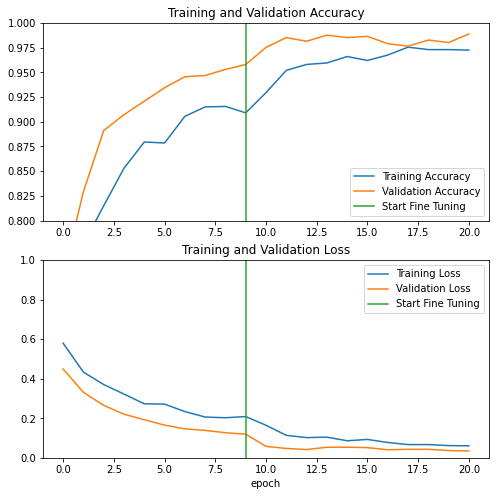

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/6 [====>.........................] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

5/6 [========================>.....] - ETA: 0s - loss: 0.0229 - accuracy: 0.9937

6/6 [==============================] - 0s 14ms/step - loss: 0.0276 - accuracy: 0.9896


Test accuracy : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0]
Labels:
 [1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0]


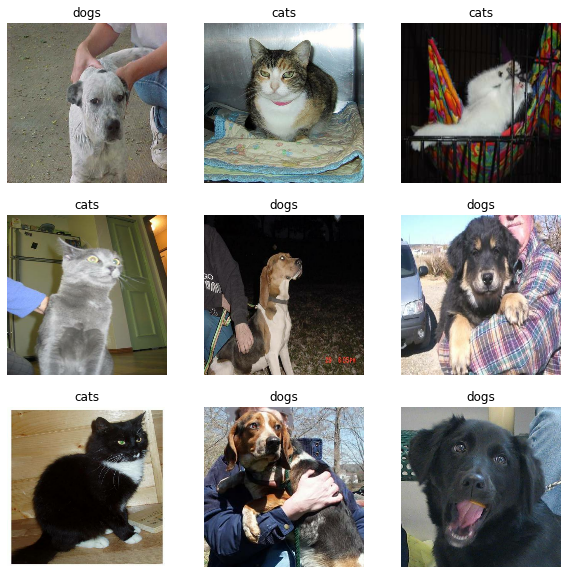

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
